# Setup

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

2024-04-29 11:44:02.464427: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-29 11:44:02.507236: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-29 11:44:02.719330: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 11:44:02.719449: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 11:44:02.720651: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

device(type='cpu')

# Data

In [3]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizing for CIFAR-10
# ])
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


trainset = torchvision.datasets.CIFAR10(root='./data_CIFAR', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data_CIFAR', train=False, download=True, transform=transform)

print(f'trainset: {type(trainset)}, testset: {len(testset)}')

Files already downloaded and verified
Files already downloaded and verified
trainset: <class 'torchvision.datasets.cifar.CIFAR10'>, testset: 10000


## Preprocessing

In [4]:
trainset.targets=torch.tensor(trainset.targets)
testset.targets=torch.tensor(testset.targets)
# label_encoder = LabelEncoder()
# trainset.targets = label_encoder.fit_transform(trainset.targets)  # Encode string labels to integers
# testset.targets = label_encoder.fit_transform(testset.targets)
# print(f'trainset: {type(trainset_encoded)}, testset: {len(testset_encoded)}')

# Model

In [5]:
class CNN_Keras_Style(nn.Module):
    def __init__(self):
        super(CNN_Keras_Style, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=3,              
                out_channels=32,            
                kernel_size=3,              
                stride=1,                   
                padding=1                  
            ),                              
            nn.ReLU(),                      
            nn.BatchNorm2d(32),
            nn.Conv2d(
                in_channels=32,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2)    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(32, 64, 3, 1, 1),     
            nn.ReLU(),                      
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)                
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)                
        )
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x, dim=1)


In [19]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [51]:
class CNN_CIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_CIFAR10, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [6]:
class Modified_CNN_CIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super(Modified_CNN_CIFAR10, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxpool1(x)
        
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.maxpool2(x)
        
        x = self.flatten(x)
        x = self.fc(x)
        return x


# FedAvg

## Hyperparameters

In [7]:
NUM_CHILDREN = 15
LEARNING_RATE = 0.05
ROUNDS = 30
EPOCHS = 1
MAX_CNT_CLIENT=500
MAX_CNT_CLIENT_TEST=300
CNT_LABELS_NON_IID_2 = 1
BATCH_SIZE=10
PERCENT_SHARED_DATA=10
WARMUP_FRACTION=0.05
LABELS = len(np.unique(np.array(trainset.targets)))
SEED=42

## Data splitter

In [8]:
def truncate_dataset_new(dataset, num_clients, max_cnt_per_client, cnt_labels_per_client=CNT_LABELS_NON_IID_2, iid=True):
    if iid:
        max_count_per_label = (max_cnt_per_client*num_clients)//LABELS
    else:
        max_count_per_label = (num_clients*cnt_labels_per_client//LABELS+1)*(max_cnt_per_client//cnt_labels_per_client)
    # label_counts = torch.bincount(dataset.targets, minlength=LABELS)
    indices_to_keep = []
    for label in range(LABELS):  # Assuming 10 classes for MNIST
        label_indices = (dataset.targets == label).nonzero().squeeze(1)
        if len(label_indices) > max_count_per_label:
            label_indices = label_indices[:max_count_per_label]
        indices_to_keep.extend(label_indices.tolist())
    truncated_dataset = torch.utils.data.Subset(dataset, indices_to_keep)
    return truncated_dataset

def split_dataset_new(dataset, num_clients, max_cnt_per_client, iid=True, cnt_labels_per_client=None, output_file="output.txt"):
    truncated_dataset = truncate_dataset_new(dataset, num_clients,cnt_labels_per_client=cnt_labels_per_client, iid=iid, max_cnt_per_client=max_cnt_per_client)
    indices = list(range(len(truncated_dataset)))
    num_samples_per_client = max_cnt_per_client
    if iid:
        random.shuffle(indices)
        splits = [indices[i*num_samples_per_client:(i+1)*num_samples_per_client] for i in range(num_clients)]
        subsets = [torch.utils.data.Subset(truncated_dataset, indices) for indices in splits]
        total = 0
    else:
        indices = sorted(indices, key=lambda i: truncated_dataset.dataset.targets[i])
        cur_index_per_label = [0]*LABELS
        cur_pointer = 0
        splits = []
        num_samples_per_client_per_label = max_cnt_per_client//cnt_labels_per_client
        max_cnt_per_label = (num_clients*cnt_labels_per_client//LABELS+1)*num_samples_per_client_per_label
        for client in range(num_clients):
            for i in range(cnt_labels_per_client):
                start = cur_index_per_label[cur_pointer]*num_samples_per_client_per_label+cur_pointer*max_cnt_per_label
                splits.append(indices[start: start+num_samples_per_client_per_label])
                cur_index_per_label[cur_pointer]=cur_index_per_label[cur_pointer]+1
                cur_pointer=(cur_pointer+1) % LABELS
        # splits = [indices[i*num_samples_per_client:(i+1)*num_samples_per_client] for i in range(num_clients)]
        subsets=[]
        val=0
        for index in range(num_clients):
            cur = splits[val]
            for count in range(1, cnt_labels_per_client):
                cur.extend(splits[val+count])
            subsets.append(torch.utils.data.Subset(truncated_dataset, cur))
            val = val+cnt_labels_per_client

    total = 0
    if output_file is not None:
        with open(output_file, "w") as f:
            for i, subset in enumerate(subsets):
                labels = [truncated_dataset.dataset.targets[i] for i in subset.indices]
                label_counts = torch.bincount(torch.tensor(labels), minlength=LABELS)  # Assuming 10 classes for MNIST
                f.write(f"Client {i} label counts:\n")
                for j, count in enumerate(label_counts):
                    f.write(f"Label {j}: {count.item()}\n")
                    total += count.item()
                f.write("\n")
            f.write(f"Total count of dataset: {total}\n")
    return subsets

In [9]:
def generate_iid_set(dataset, percent, max_cnt_per_client=MAX_CNT_CLIENT):
    total_size = (percent*max_cnt_per_client)//100
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    indices_to_keep = [indices[i] for i in range(total_size)]
    truncated_dataset = torch.utils.data.Subset(dataset, indices_to_keep)
    return truncated_dataset

In [10]:
def generate_warmup_set(dataset, warmup_fraction):
    total_size = (int)(warmup_fraction*len(dataset))
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    indices_to_keep = [indices[i] for i in range(total_size)]
    truncated_dataset = torch.utils.data.Subset(dataset, indices_to_keep)
    return truncated_dataset

## Client and host

In [11]:
class CLIENT():
    def __init__(self,train_loader,test_loader,modelClass,optim,loss_function,device,learning_rate,epochs):
        self.device = device
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.model =  modelClass().to(self.device)
        self.learning_rate = learning_rate
        self.loss_func = loss_function().to(self.device)
        self.epochs = epochs
        self.optimizer =  optim(self.model.parameters(),lr=learning_rate)
        self.results = []
    def update_params_to(self,model):
        self.model.load_state_dict(model.state_dict())
    def train_round(self):
        for epoch in range(self.epochs):
            print(f"E{epoch+1} ",end="")
            self.model.train()
            running_loss = 0.0
            for inputs,labels in self.train_loader:
                inputs,labels = inputs.to(self.device),labels.to(self.device)
                self.model.zero_grad()
                output = self.model(inputs)
                # print(output.shape)
                # print(torch.argmax(output,dim=1).shape)
                # print(labels.shape)
                loss = self.loss_func(output, labels)
                loss.backward()
                self.optimizer.step()
                # print(f" loss:{loss.item()} ")
                running_loss += loss.item()*inputs.size(0)
            # print(f"running loss:{running_loss} ")
            testing_loss = 0.0
            self.model.eval()
            with torch.no_grad():
                for inputs,labels in self.test_loader:
                    inputs,labels = inputs.to(self.device),labels.to(self.device)
                    output = self.model(inputs)
                    testing_loss+=self.loss_func(output,labels).sum().item()
                avg_loss = running_loss/len(self.train_loader.dataset)
                # print(f"avg loss:{avg_loss}\n")
            self.results.append(avg_loss)
        print("",end= "\n")

In [12]:
class HOST():
    def __init__(self,model,optimizer,loss_function,learning_rate,device,testset,trainset,epochs,rounds,
                 cnt_labels_noniid=CNT_LABELS_NON_IID_2,num_clients=NUM_CHILDREN,
                 max_cnt_per_client_train=MAX_CNT_CLIENT, max_cnt_per_client_test=MAX_CNT_CLIENT_TEST,
                 export=False,shared_data=PERCENT_SHARED_DATA,
                 warmup=False,warmup_fraction=WARMUP_FRACTION,warmup_epochs=1,
                 batch_size=BATCH_SIZE,iid=True,seed=None):
        if seed:
            torch.manual_seed(seed)
            np.random.seed(seed)
            random.seed(seed)
        self.model = model().to(device)
        self.central_train_model = model().to(device)
        self.central_train_model.load_state_dict(self.model.state_dict())
        self.central_train_optim =  optimizer(self.central_train_model.parameters(), lr=learning_rate)
        self.device=device
        self.epochs = epochs
        self.rounds = rounds
        self.export = export
        self.num_clients = num_clients
        self.loss_func = loss_function().to(device)
        self.optim = optimizer(self.model.parameters(),lr=learning_rate)
        self.lr = learning_rate
        self.rounds = rounds
        self.trainset = trainset
        self.testset = testset
        self.cnt_labels=cnt_labels_noniid
        self.train_full_dataloader = torch.utils.data.DataLoader(truncate_dataset_new(self.trainset, iid=iid, max_cnt_per_client=max_cnt_per_client_train,num_clients=self.num_clients),batch_size=self.num_clients*batch_size,shuffle=True)
        self.test_full_dataloader = torch.utils.data.DataLoader(truncate_dataset_new(self.testset, iid=iid, max_cnt_per_client=max_cnt_per_client_test, num_clients=self.num_clients),batch_size=self.num_clients*batch_size,shuffle=True)
        self.warmup_fraction = warmup_fraction*(len(self.train_full_dataloader)*num_clients*batch_size*1.0/len(trainset))
        self.clients = []
        self.results = []
        self.accuracies = []
        self.central_train_results = []
        self.batch_size = batch_size
        self.client_sample_sizes = [len(trainset)//self.num_clients]*self.num_clients
        self.test_dataloaders = [torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=False) 
                    for dataset in split_dataset_new(testset, self.num_clients,iid=iid, max_cnt_per_client=max_cnt_per_client_test,cnt_labels_per_client=self.cnt_labels)]
        self.train_dataloaders = [torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=False) 
                     for dataset in split_dataset_new(trainset, self.num_clients,iid=iid, max_cnt_per_client=max_cnt_per_client_train,cnt_labels_per_client=self.cnt_labels)]
        self.layer_names = []
        self.divergences_per_layer = {name: [] for name, _ in self.model.named_parameters()}
        self.subset_iid_data=None
        if warmup:
            self.warm_train = generate_warmup_set(trainset, self.warmup_fraction)
            # self.warm_test = generate_iid_set(testset, warmup_fraction*100)
            optim = optimizer(self.model.parameters(), lr=learning_rate)
            self.warm_train = torch.utils.data.DataLoader(
                self.warm_train,batch_size=self.batch_size,shuffle=True
            )
            # self.warm_test = torch.utils.data.DataLoader(
            #     self.warm_test,batch_size=self.batch_size,shuffle=True
            # )

            print("Warmup: ")
            for epoch in range(warmup_epochs):
                print(f"E{epoch+1} ",end=" ")
                self.model.train()
                running_loss=0.0
                for inputs,labels in self.warm_train:
                    inputs,labels = inputs.to(device),labels.to(device)
                    self.model.zero_grad()
                    output = self.model(inputs)
                    loss = self.loss_func(output, labels)
                    loss.backward()
                    optim.step()
                    running_loss += loss.item()*inputs.size(0)
            print()
            self.central_train_model.load_state_dict(self.model.state_dict())
        if self.export:
            self.subset_iid_data = torch.utils.data.DataLoader(generate_iid_set(self.trainset, shared_data), batch_size=self.batch_size, shuffle=True)
            for i in range(self.num_clients):
                new_client = CLIENT(
                    train_loader=torch.utils.data.DataLoader(torch.utils.data.ConcatDataset([self.train_dataloaders[i].dataset, self.subset_iid_data.dataset]), batch_size=self.batch_size, shuffle=True),
                    test_loader=self.test_dataloaders[i],
                    device=self.device,
                    modelClass=model,
                    optim=optimizer,
                    loss_function=loss_function,
                    learning_rate=learning_rate,
                    epochs=epochs
                )
                new_client.update_params_to(self.model)
                self.clients.append(new_client)
        else:
            for i in range(self.num_clients):
                new_client = CLIENT(
                    train_loader=self.train_dataloaders[i],
                    test_loader=self.test_dataloaders[i],
                    device=self.device,
                    modelClass=model,
                    optim=optimizer,
                    loss_function=loss_function,
                    learning_rate=learning_rate,
                    epochs=epochs
                )
                new_client.update_params_to(self.model)
                self.clients.append(new_client)
        # print(len(self.train_full_dataloader))
    def aggr_round(self):
        local_params= []
        for i in range(self.num_clients):
            print(f"Client {i} is training.")
            client = self.clients[i]
            client.train_round()
            state_dict = client.model.state_dict()
            for key,value in state_dict.items():
                state_dict[key] = value/self.num_clients
            # state_dict = state_dict/self.num_clients
            local_params.append(state_dict)
        weighted_param_sum = local_params[0]
        for params in local_params[1:]:
            for key,value in params.items():
                weighted_param_sum[key] = weighted_param_sum.get(key) + value
        self.model.load_state_dict(weighted_param_sum)
        for client in self.clients:
            client.update_params_to(self.model)
        with torch.no_grad():
            self.model.eval()
            test_loss = 0.0
            for inputs,labels in self.test_full_dataloader:
                inputs,labels = inputs.to(self.device),labels.to(self.device)
                output = self.model(inputs)
                test_loss+=self.loss_func(output,labels)
            avg_loss = test_loss/len(self.test_full_dataloader.dataset)
            # self.results.append(avg_loss)
    def test_aggr(self):
        self.model.eval()
        correct = 0
        total = 0
        running_loss=0.0
        with torch.no_grad():
            for inputs,labels in self.test_full_dataloader:
                inputs,labels = inputs.to(self.device),labels.to(self.device)
                outputs = self.model(inputs)
                loss=self.loss_func(outputs, labels)
                running_loss+=loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct/total
        self.accuracies.append(accuracy)
        avg_loss = (running_loss/len(self.test_full_dataloader))
        return avg_loss
    def test_central(self):
        self.central_train_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs,labels in self.test_full_dataloader:
                inputs,labels = inputs.to(self.device),labels.to(self.device)
                outputs = self.central_train_model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return correct / total

    def do_rounds(self):
        for i in range(self.rounds):
            print(f"Round: {i+1}")
            self.aggr_round()
            self.store_divergence()
            loss = self.test_aggr()
            self.results.append(loss)
            print(f"Loss: {loss}")
    def central_train(self):
        for epoch in range(self.epochs*self.rounds):
            print(f"E{epoch+1} ",end="")
            self.central_train_model.train()
            running_loss = 0.0
            for inputs,labels in self.train_full_dataloader:
                inputs,labels = inputs.to(self.device),labels.to(self.device)
                self.central_train_model.zero_grad()
                output = self.central_train_model(inputs)
                # print(output.shape)
                # print(torch.argmax(output,dim=1).shape)
                # print(labels.shape)
                loss = self.loss_func(output, labels)
                loss.backward()
                self.central_train_optim.step()
                running_loss += loss.item()*inputs.size(0)
            testing_loss = 0.0
            self.model.eval()
            with torch.no_grad():
                for inputs,labels in self.test_full_dataloader:
                    inputs,labels = inputs.to(self.device),labels.to(self.device)
                    output = self.model(inputs)
                    testing_loss+=self.loss_func(output,labels).sum().item()
                avg_loss = (running_loss/len(self.test_full_dataloader.dataset))
            self.central_train_results.append(avg_loss)
            # self.central_train_results.append(running_loss)
        print("",end= "\n")
    def dispaly(self,plot_clients=False,plot_epochs=True):
        if plot_clients:
            for i in range(self.num_clients):
                client = self.clients[i]
                plt.plot(client.results,label=f"{i}")
        plt.plot(self.central_train_results,label=f"C")
        res_x = [(i+1)*self.epochs-1 for i in range(self.rounds)]
        res_y = self.results
        plt.scatter(res_x,res_y,label="F")
        if plot_epochs:
            for i in range(1,self.rounds+1):
                plt.axvline(x=i*self.epochs-1,color='b')
        plt.legend()
        plt.show()
    def run_central_and_federated_and_display(self,plot_clients=False,plot_epochs=True):
        print("Training centralized model:")
        self.central_train()
        central_accuracy = self.test_central()
        print(f"Central Accuracy: {100*central_accuracy}")
        self.do_rounds()
        self.dispaly(plot_clients=plot_clients,plot_epochs=plot_epochs)
    def plot_divergence(self):
        central_stuff = dict()
        federated_stuff = dict()
        diff = dict()

        for name,layer in self.model.named_parameters():
            federated_stuff[name] = np.array(layer.detach().to("cpu"))

        for name,layer in self.central_train_model.named_parameters():
            central_stuff[name] = np.array(layer.detach().to("cpu"))

        for layer_name in central_stuff.keys():
            diff[layer_name] = np.std((central_stuff[layer_name]-federated_stuff[layer_name]))

        plt.figure(figsize=(12,6))
        plt.bar(diff.keys( ), diff.values())
        for i, value in enumerate(diff.values()):
            plt.annotate(str(round(value, 5)), xy=(i, value), ha='center', va='bottom')
        plt.ylabel("Std. Dev. of difference")
        plt.xlabel("Layer")
        plt.xticks(rotation=45)

        plt.show()
    def store_divergence(self):
        central_stuff = dict()
        federated_stuff = dict()

        for name, layer in self.model.named_parameters():
            federated_stuff[name] = np.array(layer.detach().to("cpu"))

        for name, layer in self.central_train_model.named_parameters():
            central_stuff[name] = np.array(layer.detach().to("cpu"))

        for layer_name in central_stuff.keys():
            divergence = np.std((central_stuff[layer_name] - federated_stuff[layer_name]))
            self.divergences_per_layer[layer_name].append(divergence)
            if len(self.layer_names) == 0 or layer_name not in self.layer_names:
                self.layer_names.append(layer_name)
    def plot_weight_divergence(self):
        plt.figure(figsize=(12, 8))
        for layer_name in self.layer_names:
            plt.plot(range(1, self.rounds + 1), self.divergences_per_layer[layer_name], marker='o', label=layer_name)
        plt.xlabel('Communication Rounds')
        plt.ylabel('Weight Divergence')
        plt.title('Weight Divergence for Each Layer vs Communication Rounds')
        plt.legend()
        plt.grid(True)
        plt.show()
    def plot_accuracy_per_round(self):
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, self.rounds + 1), self.accuracies, marker='o', )
        plt.xlabel('Communication Rounds')
        plt.ylabel('Fed Avg Accuracy')
        plt.title('Accuracy vs Communication Rounds')
        plt.grid(True)
        plt.show()


## IID

In [16]:
host0 = HOST(
    model=Modified_CNN_CIFAR10,
    optimizer=optim.SGD,
    loss_function=nn.CrossEntropyLoss,
    learning_rate=LEARNING_RATE,
    device=device,
    num_clients=NUM_CHILDREN,
    testset=testset,
    trainset=trainset,
    epochs=EPOCHS,
    rounds=ROUNDS,
    seed=SEED
)

Training centralized model:
E1 E2 E3 E4 E5 E6 E7 E8 E9 E10 E11 E12 E13 E14 E15 E16 E17 E18 E19 E20 E21 E22 E23 E24 E25 E26 E27 E28 E29 E30 
Central Accuracy: 66.93333333333334
Round: 1
Client 0 is training.
E1 
Client 1 is training.
E1 
Client 2 is training.
E1 
Client 3 is training.
E1 
Client 4 is training.
E1 
Client 5 is training.
E1 
Client 6 is training.
E1 
Client 7 is training.
E1 
Client 8 is training.
E1 
Client 9 is training.
E1 
Client 10 is training.
E1 
Client 11 is training.
E1 
Client 12 is training.
E1 
Client 13 is training.
E1 
Client 14 is training.
E1 
Loss: 2.294154747327169
Round: 2
Client 0 is training.
E1 
Client 1 is training.
E1 
Client 2 is training.
E1 
Client 3 is training.
E1 
Client 4 is training.
E1 
Client 5 is training.
E1 
Client 6 is training.
E1 
Client 7 is training.
E1 
Client 8 is training.
E1 
Client 9 is training.
E1 
Client 10 is training.
E1 
Client 11 is training.
E1 
Client 12 is training.
E1 
Client 13 is training.
E1 
Client 14 is traini

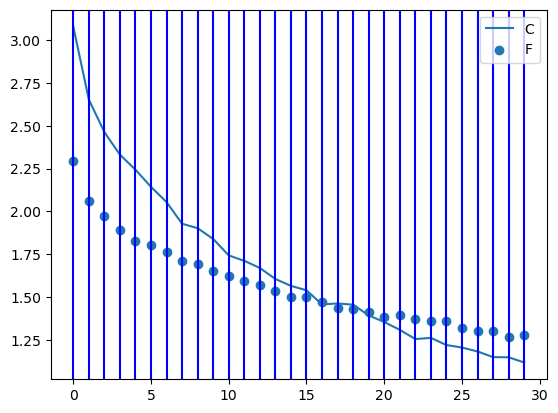

In [17]:
host0.run_central_and_federated_and_display()

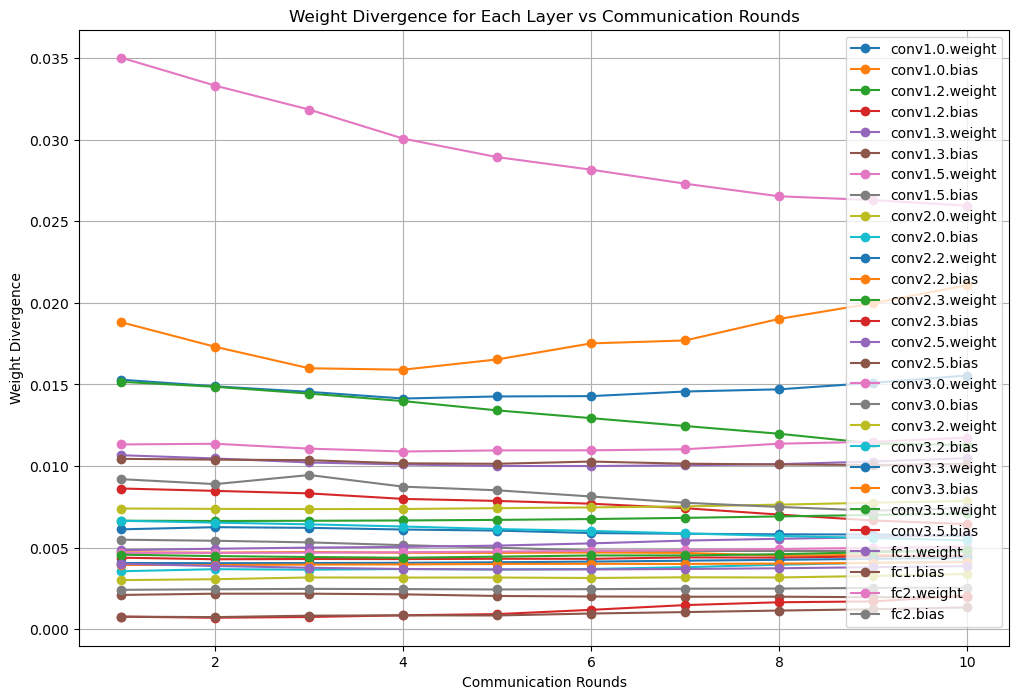

In [81]:
host0.plot_weight_divergence()

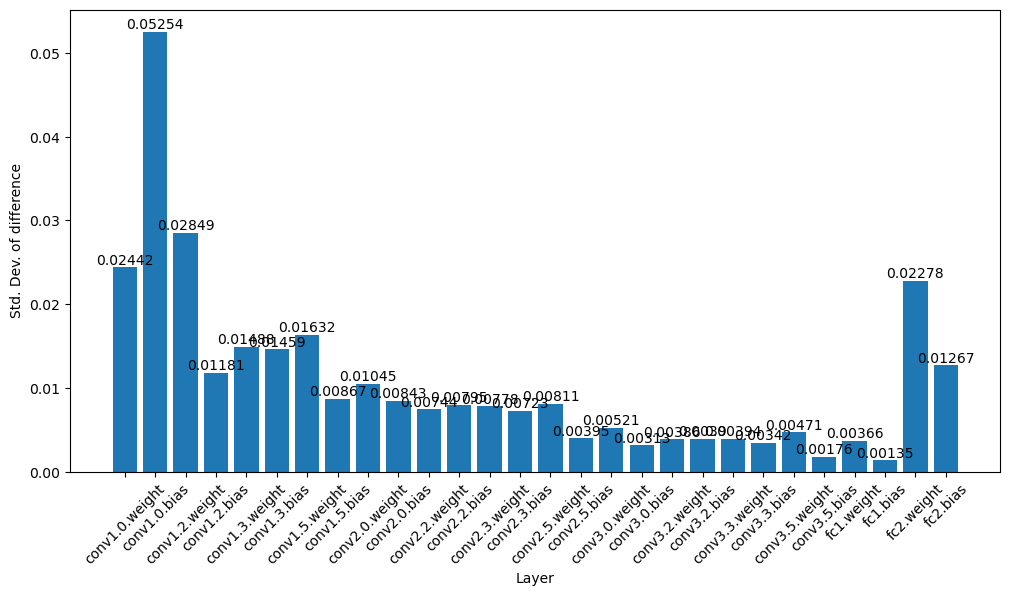

In [22]:
host0.plot_divergence()

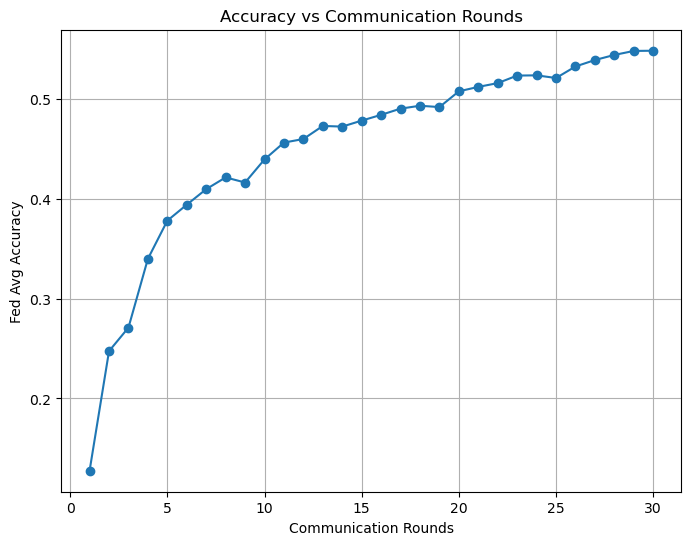

In [18]:
host0.plot_accuracy_per_round()

## Non IID

In [65]:
host1 = HOST(
    model=Modified_CNN_CIFAR10,
    optimizer=optim.SGD,
    loss_function=nn.CrossEntropyLoss,
    learning_rate=LEARNING_RATE,
    device=device,
    num_clients=NUM_CHILDREN,
    testset=testset,
    trainset=trainset,
    epochs=EPOCHS,
    rounds=ROUNDS,
    iid=False,
    seed=SEED
)

Training centralized model:
E1 E2 E3 E4 E5 E6 E7 E8 E9 E10 E11 E12 E13 E14 E15 E16 E17 E18 E19 E20 E21 E22 E23 E24 E25 E26 E27 E28 E29 E30 
Central Accuracy: 68.45
Round: 1
Client 0 is training.
E1 
Client 1 is training.
E1 
Client 2 is training.
E1 
Client 3 is training.
E1 
Client 4 is training.
E1 
Client 5 is training.
E1 
Client 6 is training.
E1 
Client 7 is training.
E1 
Client 8 is training.
E1 
Client 9 is training.
E1 
Client 10 is training.
E1 
Client 11 is training.
E1 
Client 12 is training.
E1 
Client 13 is training.
E1 
Client 14 is training.
E1 
Loss: 8.264265656471252
Round: 2
Client 0 is training.
E1 
Client 1 is training.
E1 
Client 2 is training.
E1 
Client 3 is training.
E1 
Client 4 is training.
E1 
Client 5 is training.
E1 
Client 6 is training.
E1 
Client 7 is training.
E1 
Client 8 is training.
E1 
Client 9 is training.
E1 
Client 10 is training.
E1 
Client 11 is training.
E1 
Client 12 is training.
E1 
Client 13 is training.
E1 
Client 14 is training.
E1 
Loss

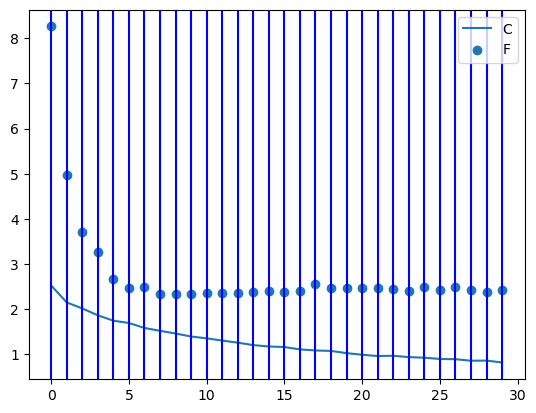

In [66]:
host1.run_central_and_federated_and_display()

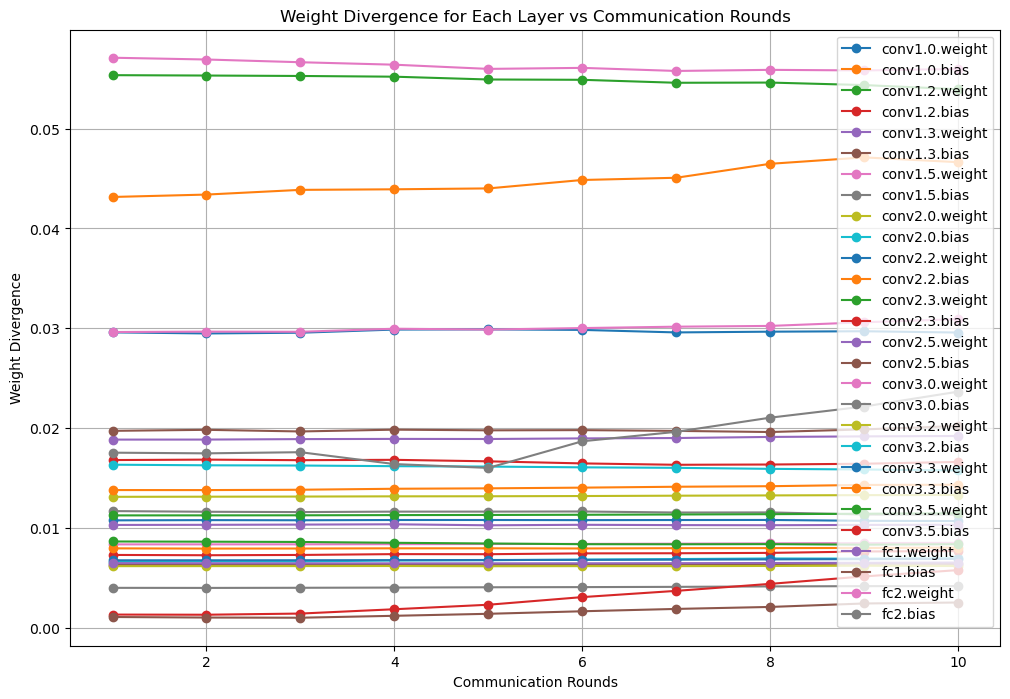

In [61]:
host1.plot_weight_divergence()

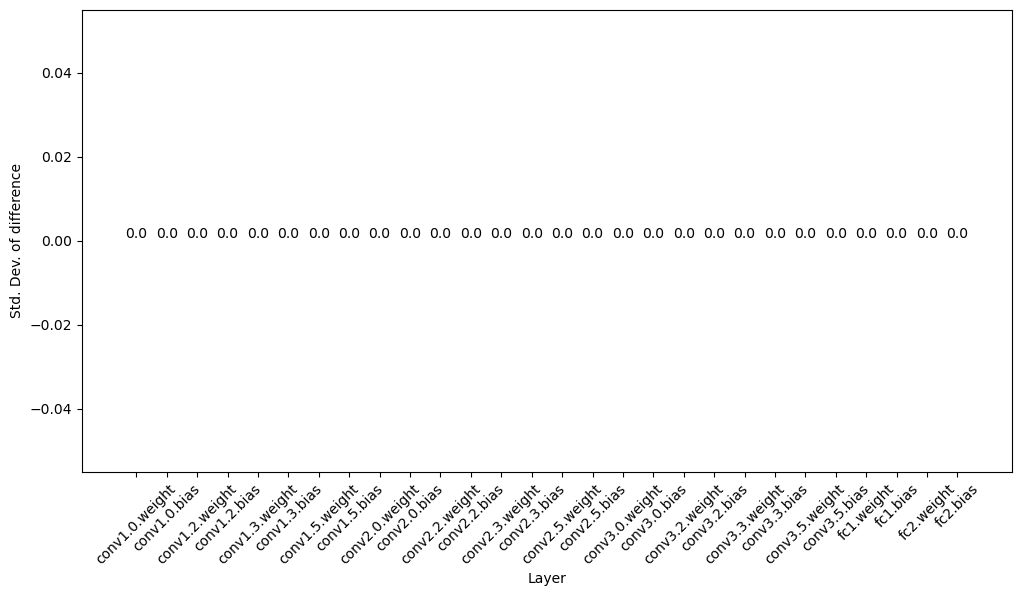

In [32]:
host1.plot_divergence()

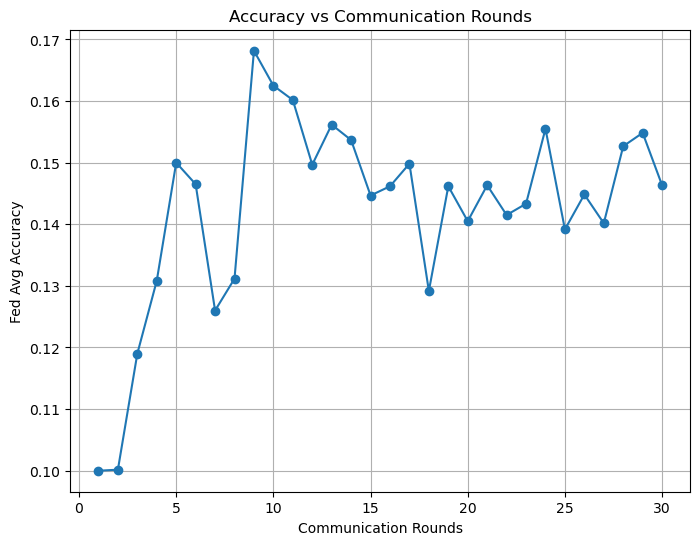

In [67]:
host1.plot_accuracy_per_round()

## Sharing a small subset of IID data

In [ ]:
host2 = HOST(
    model=CNN_Keras_Style,
    optimizer=optim.SGD,
    loss_function=nn.CrossEntropyLoss,
    learning_rate=LEARNING_RATE,
    device=device,
    num_clients=NUM_CHILDREN,
    testset=testset,
    trainset=trainset,
    epochs=EPOCHS,
    rounds=ROUNDS,
    iid=False,
    export=True,
    shared_data=PERCENT_SHARED_DATA,
    seed=SEED
)

Training centralized model:
E1 E2 E3 E4 E5 E6 E7 E8 E9 E10 E11 E12 E13 E14 E15 E16 E17 E18 E19 E20 
Central Accuracy: 70.86666666666666
Round: 1
Client 0 is training.
E1 E2 
Client 1 is training.
E1 E2 
Client 2 is training.
E1 E2 
Client 3 is training.
E1 E2 
Client 4 is training.
E1 E2 
Client 5 is training.
E1 E2 
Client 6 is training.
E1 E2 
Client 7 is training.
E1 E2 
Client 8 is training.
E1 E2 
Client 9 is training.
E1 E2 
Client 10 is training.
E1 E2 
Client 11 is training.
E1 E2 
Client 12 is training.
E1 E2 
Client 13 is training.
E1 E2 
Client 14 is training.
E1 E2 
Client 15 is training.
E1 E2 
Client 16 is training.
E1 E2 
Client 17 is training.
E1 E2 
Client 18 is training.
E1 E2 
Client 19 is training.
E1 E2 
Loss: 2.302982139587402
Round: 2
Client 0 is training.
E1 E2 
Client 1 is training.
E1 E2 
Client 2 is training.
E1 E2 
Client 3 is training.
E1 E2 
Client 4 is training.
E1 E2 
Client 5 is training.
E1 E2 
Client 6 is training.
E1 E2 
Client 7 is training.
E1 E2 


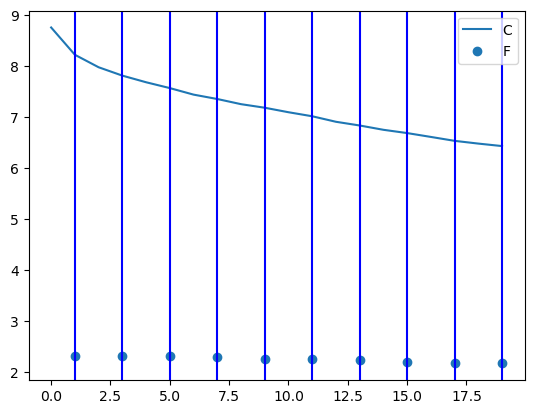

In [ ]:
host2.run_central_and_federated_and_display()

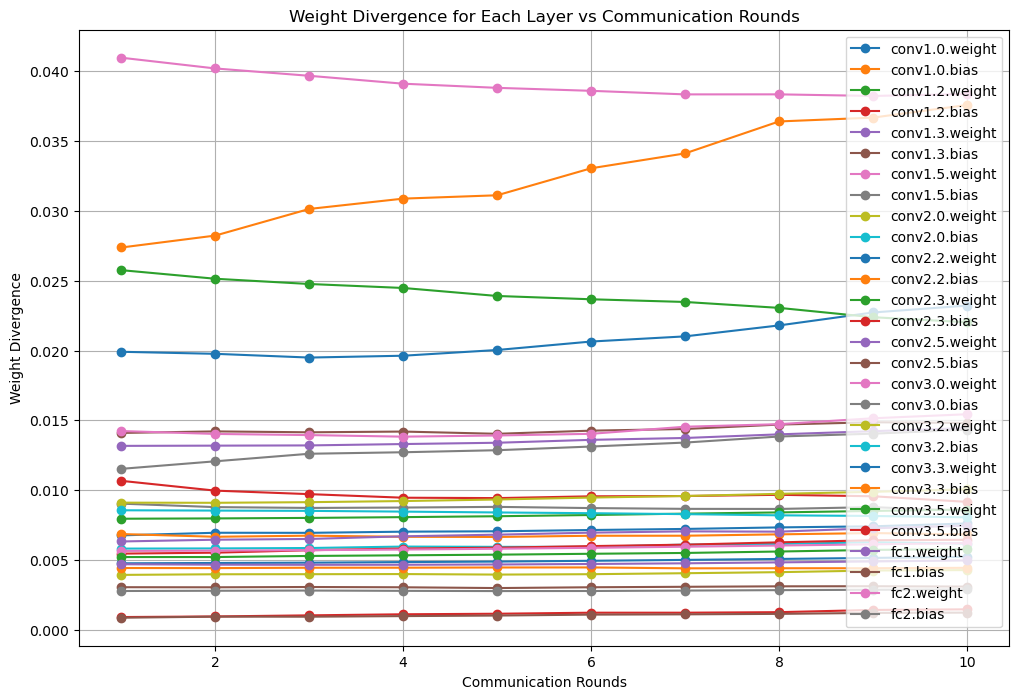

In [91]:
host2.plot_weight_divergence()

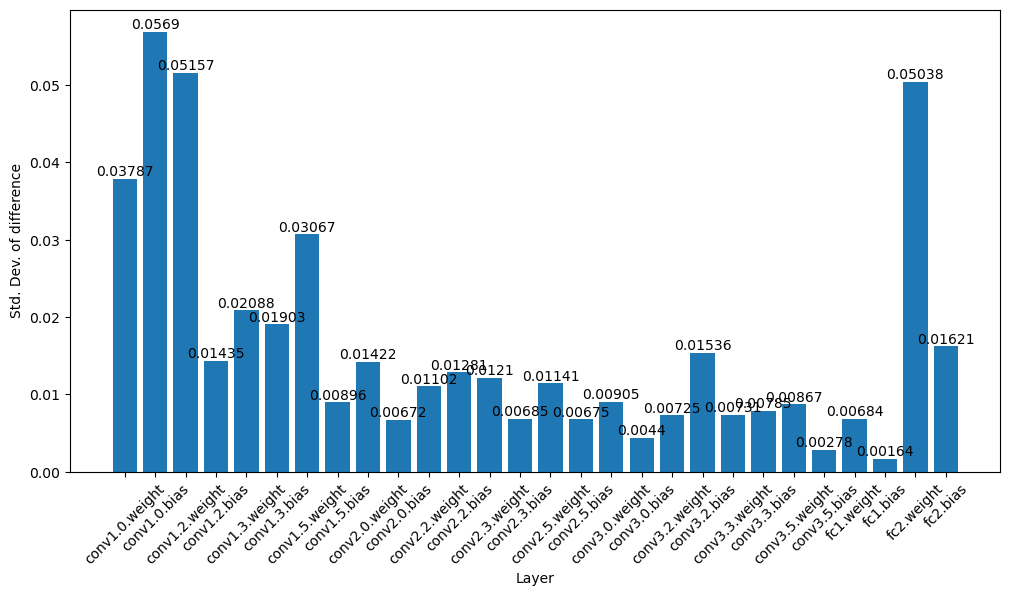

In [76]:
host2.plot_divergence()

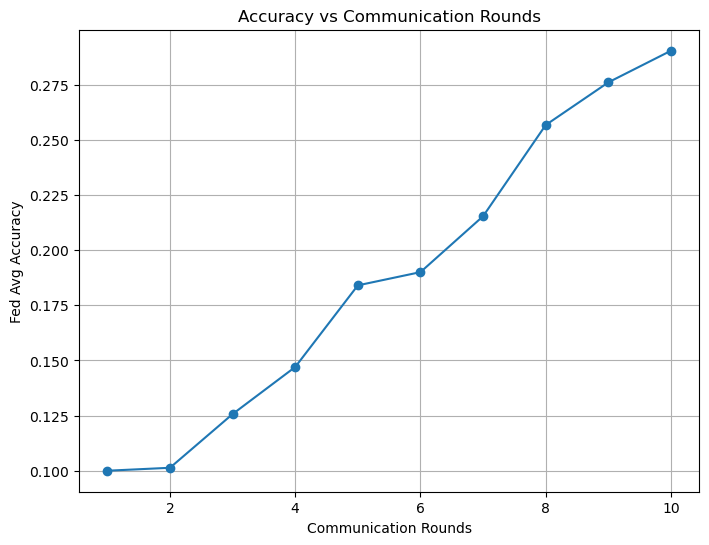

In [68]:
host2.plot_accuracy_per_round()

## Comparing Class-2 Non-IID & IID

In [ ]:
host3 = HOST(
    model=CNN_Keras_Style,
    optimizer=optim.SGD,
    loss_function=nn.CrossEntropyLoss,
    learning_rate=LEARNING_RATE,
    device=device,
    num_clients=NUM_CHILDREN,
    testset=testset,
    trainset=trainset,
    epochs=EPOCHS,
    rounds=ROUNDS,
    iid=False,
    cnt_labels_noniid=2,
    seed=SEED
)

Training centralized model:
E1 E2 E3 E4 E5 E6 E7 E8 E9 E10 E11 E12 E13 E14 E15 E16 E17 E18 E19 E20 
Central Accuracy: 70.86666666666666
Round: 1
Client 0 is training.
E1 E2 
Client 1 is training.
E1 E2 
Client 2 is training.
E1 E2 
Client 3 is training.
E1 E2 
Client 4 is training.
E1 E2 
Client 5 is training.
E1 E2 
Client 6 is training.
E1 E2 
Client 7 is training.
E1 E2 
Client 8 is training.
E1 E2 
Client 9 is training.
E1 E2 
Client 10 is training.
E1 E2 
Client 11 is training.
E1 E2 
Client 12 is training.
E1 E2 
Client 13 is training.
E1 E2 
Client 14 is training.
E1 E2 
Client 15 is training.
E1 E2 
Client 16 is training.
E1 E2 
Client 17 is training.
E1 E2 
Client 18 is training.
E1 E2 
Client 19 is training.
E1 E2 
Loss: 2.3029348055521646
Round: 2
Client 0 is training.
E1 E2 
Client 1 is training.
E1 E2 
Client 2 is training.
E1 E2 
Client 3 is training.
E1 E2 
Client 4 is training.
E1 E2 
Client 5 is training.
E1 E2 
Client 6 is training.
E1 E2 
Client 7 is training.
E1 E2 

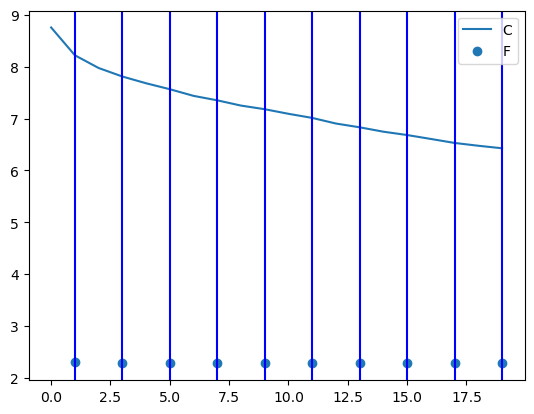

In [ ]:
host3.run_central_and_federated_and_display()

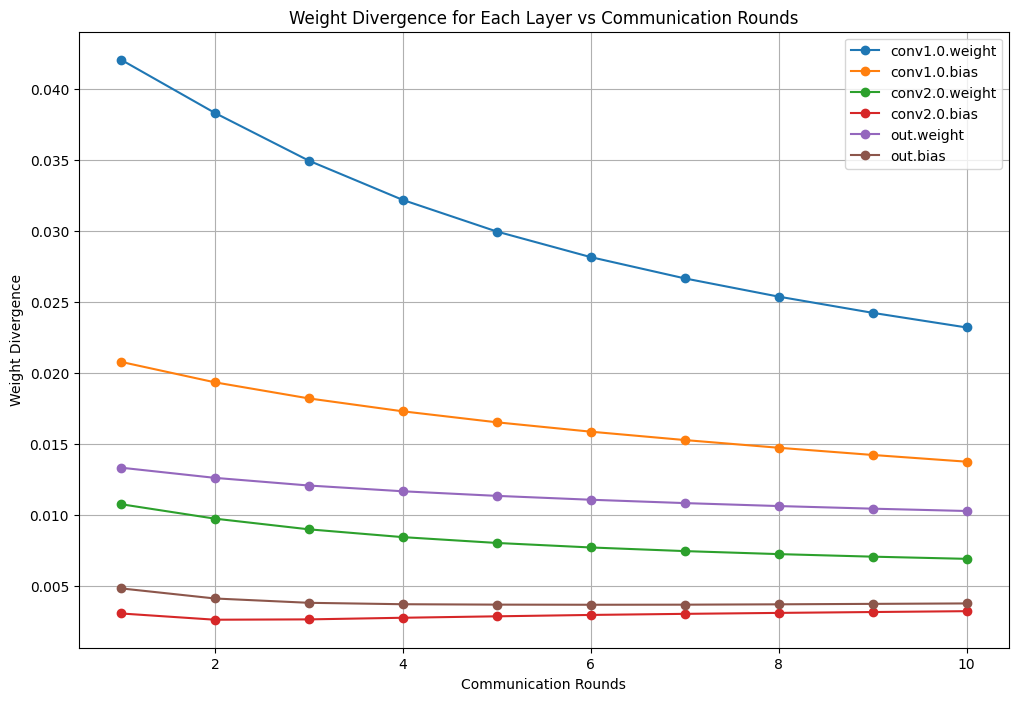

In [120]:
host3.plot_weight_divergence()

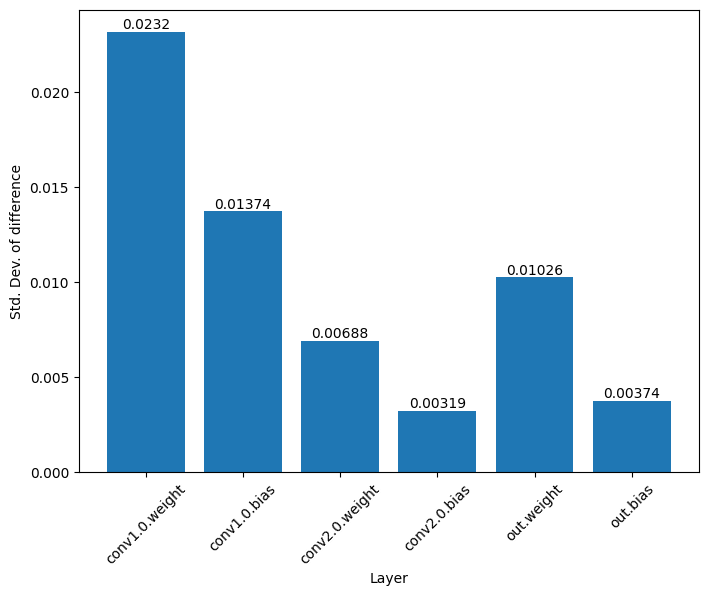

In [121]:
host3.plot_divergence()

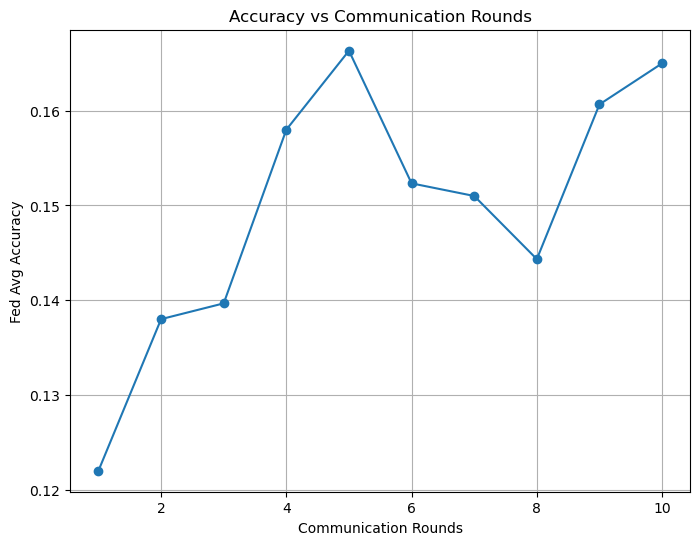

In [86]:
host3.plot_accuracy_per_round()

In [ ]:
host4 = HOST(
    model=CNN_Keras_Style,
    optimizer=optim.SGD,
    loss_function=nn.CrossEntropyLoss,
    learning_rate=LEARNING_RATE,
    device=device,
    num_clients=NUM_CHILDREN,
    testset=testset,
    trainset=trainset,
    epochs=EPOCHS,
    rounds=ROUNDS,
    iid=False,
    cnt_labels_noniid=5,
    seed=SEED
)

Training centralized model:
E1 E2 E3 E4 E5 E6 E7 E8 E9 E10 E11 E12 E13 E14 E15 E16 E17 E18 E19 E20 
Central Accuracy: 70.86666666666666
Round: 1
Client 0 is training.
E1 E2 
Client 1 is training.
E1 E2 
Client 2 is training.
E1 E2 
Client 3 is training.
E1 E2 
Client 4 is training.
E1 E2 
Client 5 is training.
E1 E2 
Client 6 is training.
E1 E2 
Client 7 is training.
E1 E2 
Client 8 is training.
E1 E2 
Client 9 is training.
E1 E2 
Client 10 is training.
E1 E2 
Client 11 is training.
E1 E2 
Client 12 is training.
E1 E2 
Client 13 is training.
E1 E2 
Client 14 is training.
E1 E2 
Client 15 is training.
E1 E2 
Client 16 is training.
E1 E2 
Client 17 is training.
E1 E2 
Client 18 is training.
E1 E2 
Client 19 is training.
E1 E2 
Loss: 2.3001908620198566
Round: 2
Client 0 is training.
E1 E2 
Client 1 is training.
E1 E2 
Client 2 is training.
E1 E2 
Client 3 is training.
E1 E2 
Client 4 is training.
E1 E2 
Client 5 is training.
E1 E2 
Client 6 is training.
E1 E2 
Client 7 is training.
E1 E2 

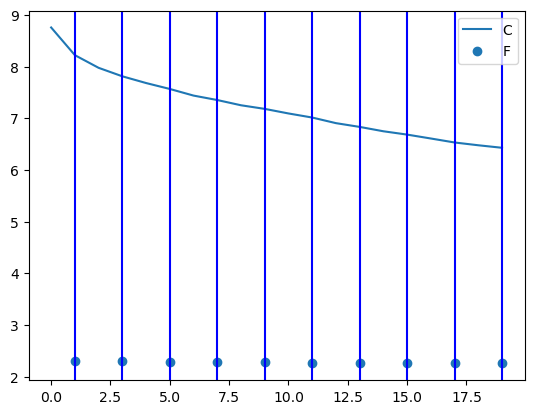

In [ ]:
host4.run_central_and_federated_and_display()

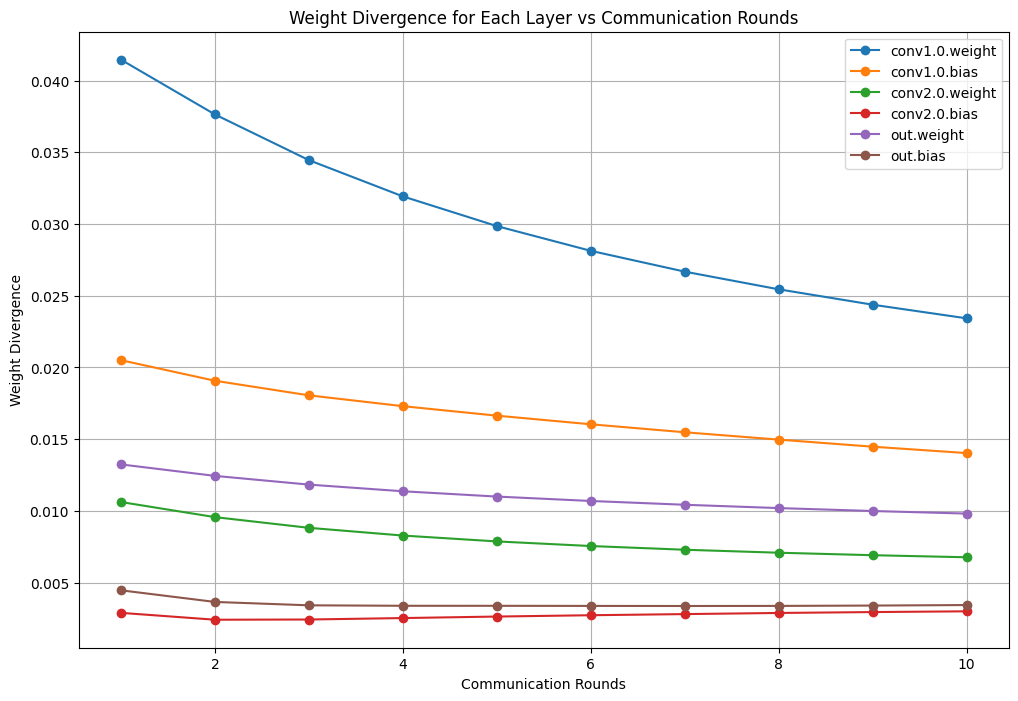

In [125]:
host4.plot_weight_divergence()

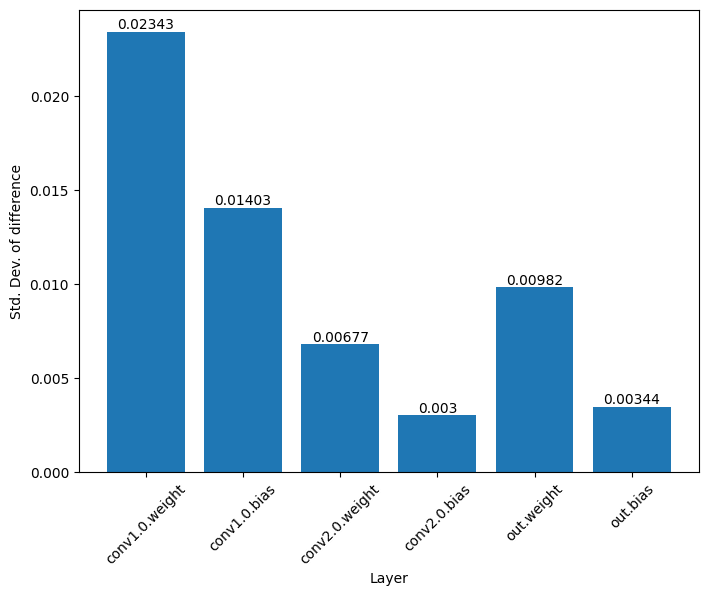

In [126]:
host4.plot_divergence()

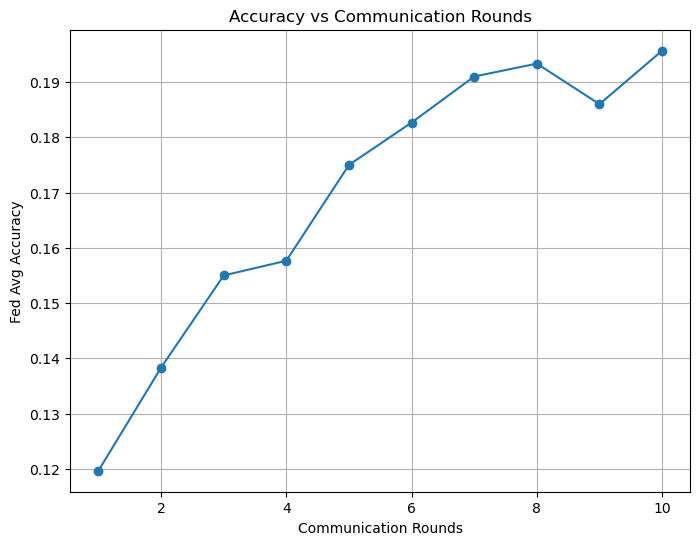

In [85]:
host4.plot_accuracy_per_round()

## Implementing Warm up Model

In [ ]:
host5 = HOST(
    model=CNN_Keras_Style,
    optimizer=optim.SGD,
    loss_function=nn.CrossEntropyLoss,
    learning_rate=LEARNING_RATE,
    device=device,
    num_clients=NUM_CHILDREN,
    testset=testset,
    trainset=trainset,
    epochs=EPOCHS,
    rounds=ROUNDS,
    iid=False,
    warmup=True,
    warmup_epochs=3,
    warmup_fraction=0.3,
    seed=SEED
)

Warmup: 
E1  E2  E3  


Training centralized model:
E1 E2 E3 E4 E5 E6 E7 E8 E9 E10 E11 E12 E13 E14 E15 E16 E17 E18 E19 E20 
Central Accuracy: 55.36666666666667
Round: 1
Client 0 is training.
E1 E2 
Client 1 is training.
E1 E2 
Client 2 is training.
E1 E2 
Client 3 is training.
E1 E2 
Client 4 is training.
E1 E2 
Client 5 is training.
E1 E2 
Client 6 is training.
E1 E2 
Client 7 is training.
E1 E2 
Client 8 is training.
E1 E2 
Client 9 is training.
E1 E2 
Client 10 is training.
E1 E2 
Client 11 is training.
E1 E2 
Client 12 is training.
E1 E2 
Client 13 is training.
E1 E2 
Client 14 is training.
E1 E2 
Client 15 is training.
E1 E2 
Client 16 is training.
E1 E2 
Client 17 is training.
E1 E2 
Client 18 is training.
E1 E2 
Client 19 is training.
E1 E2 
Loss: 2.2213652610778807
Round: 2
Client 0 is training.
E1 E2 
Client 1 is training.
E1 E2 
Client 2 is training.
E1 E2 
Client 3 is training.
E1 E2 
Client 4 is training.
E1 E2 
Client 5 is training.
E1 E2 
Client 6 is training.
E1 E2 
Client 7 is training.
E1 E2 

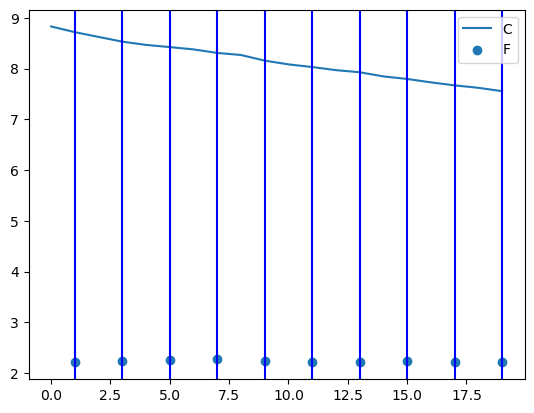

In [ ]:
host5.run_central_and_federated_and_display()

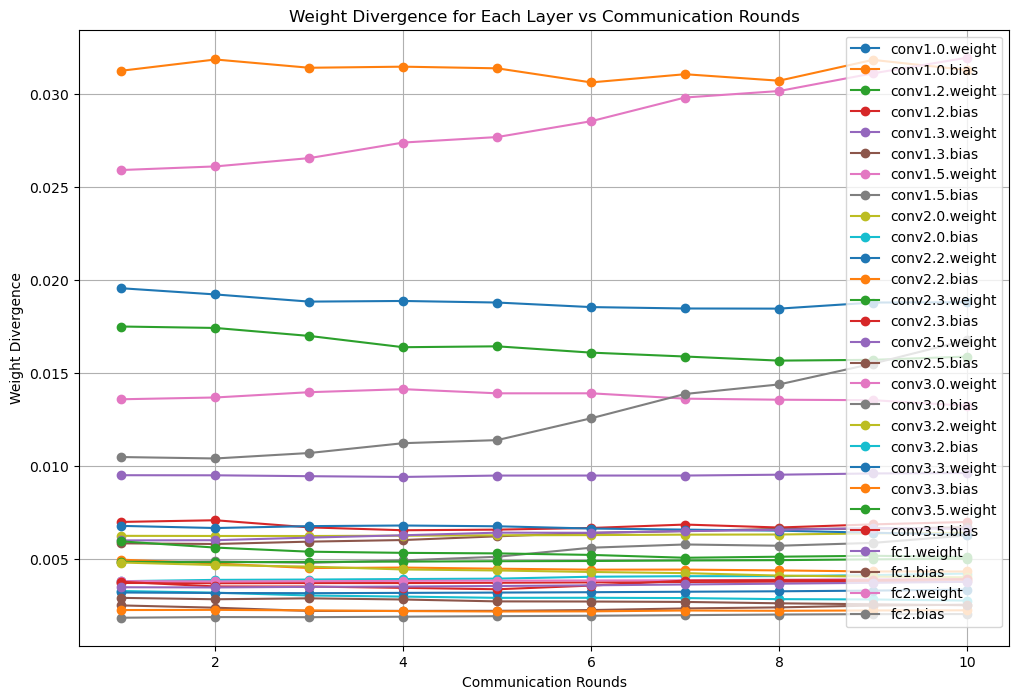

In [96]:
host5.plot_weight_divergence()

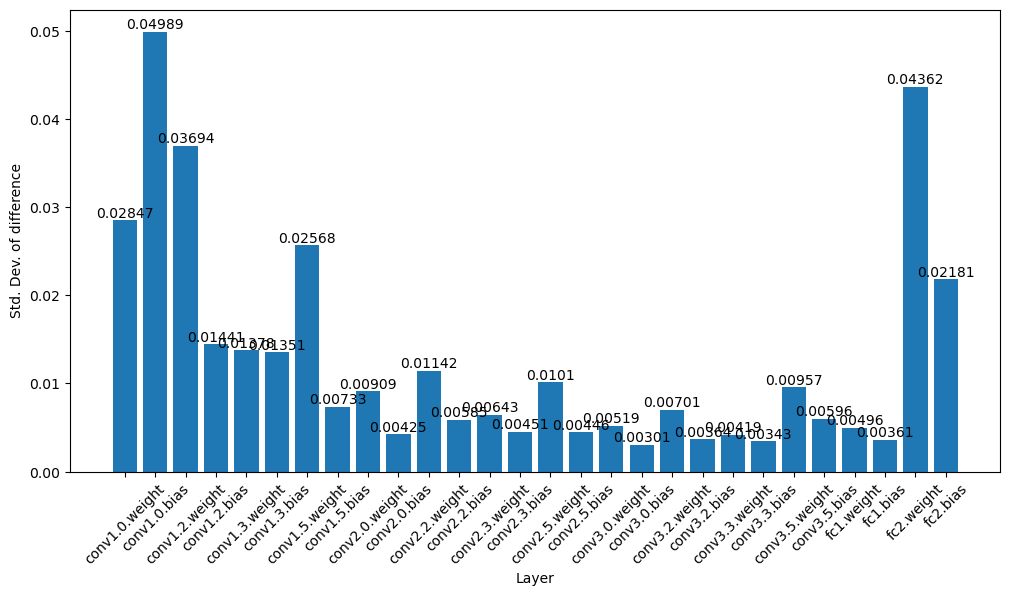

In [78]:
host5.plot_divergence()

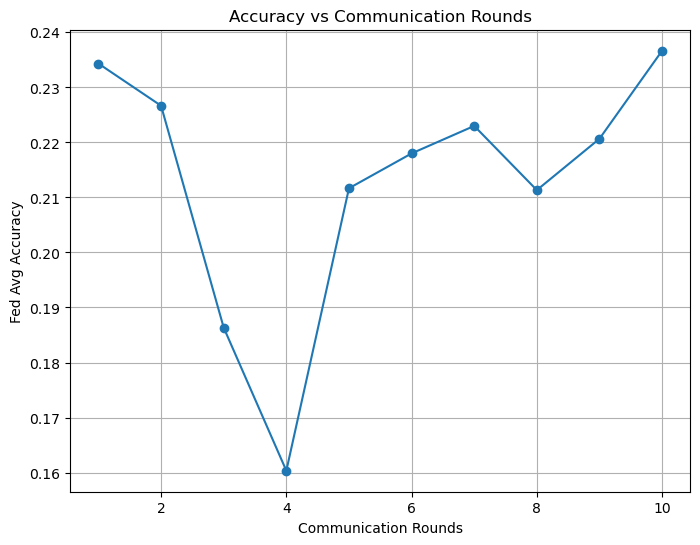

In [75]:
host5.plot_accuracy_per_round()

## Warmup with global IID subset

In [ ]:
host6 = HOST(
    model=CNN_Keras_Style,
    optimizer=optim.SGD,
    loss_function=nn.CrossEntropyLoss,
    learning_rate=LEARNING_RATE,
    device=device,
    num_clients=NUM_CHILDREN,
    testset=testset,
    trainset=trainset,
    epochs=EPOCHS,
    rounds=ROUNDS,
    iid=False,
    warmup=True,
    warmup_epochs=3,
    warmup_fraction=0.3,
    export=True,
    shared_data=PERCENT_SHARED_DATA,
    seed=SEED
)

Warmup: 
E1  E2  E3  


Training centralized model:
E1 E2 E3 E4 E5 E6 E7 E8 E9 E10 E11 E12 E13 E14 E15 E16 E17 E18 E19 E20 
Central Accuracy: 55.36666666666667
Round: 1
Client 0 is training.
E1 E2 
Client 1 is training.
E1 E2 
Client 2 is training.
E1 E2 
Client 3 is training.
E1 E2 
Client 4 is training.
E1 E2 
Client 5 is training.
E1 E2 
Client 6 is training.
E1 E2 
Client 7 is training.
E1 E2 
Client 8 is training.
E1 E2 
Client 9 is training.
E1 E2 
Client 10 is training.
E1 E2 
Client 11 is training.
E1 E2 
Client 12 is training.
E1 E2 
Client 13 is training.
E1 E2 
Client 14 is training.
E1 E2 
Client 15 is training.
E1 E2 
Client 16 is training.
E1 E2 
Client 17 is training.
E1 E2 
Client 18 is training.
E1 E2 
Client 19 is training.
E1 E2 
Loss: 2.2181210199991863
Round: 2
Client 0 is training.
E1 E2 
Client 1 is training.
E1 E2 
Client 2 is training.
E1 E2 
Client 3 is training.
E1 E2 
Client 4 is training.
E1 E2 
Client 5 is training.
E1 E2 
Client 6 is training.
E1 E2 
Client 7 is training.
E1 E2 

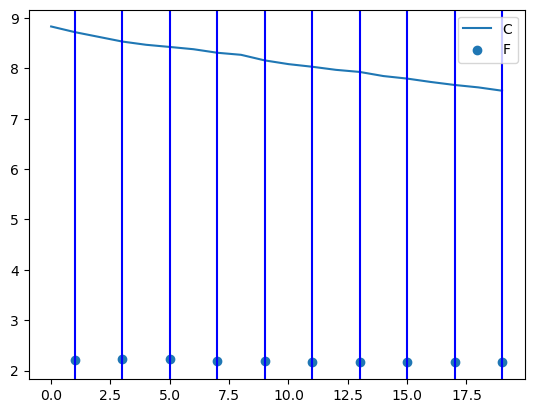

In [ ]:
host6.run_central_and_federated_and_display()

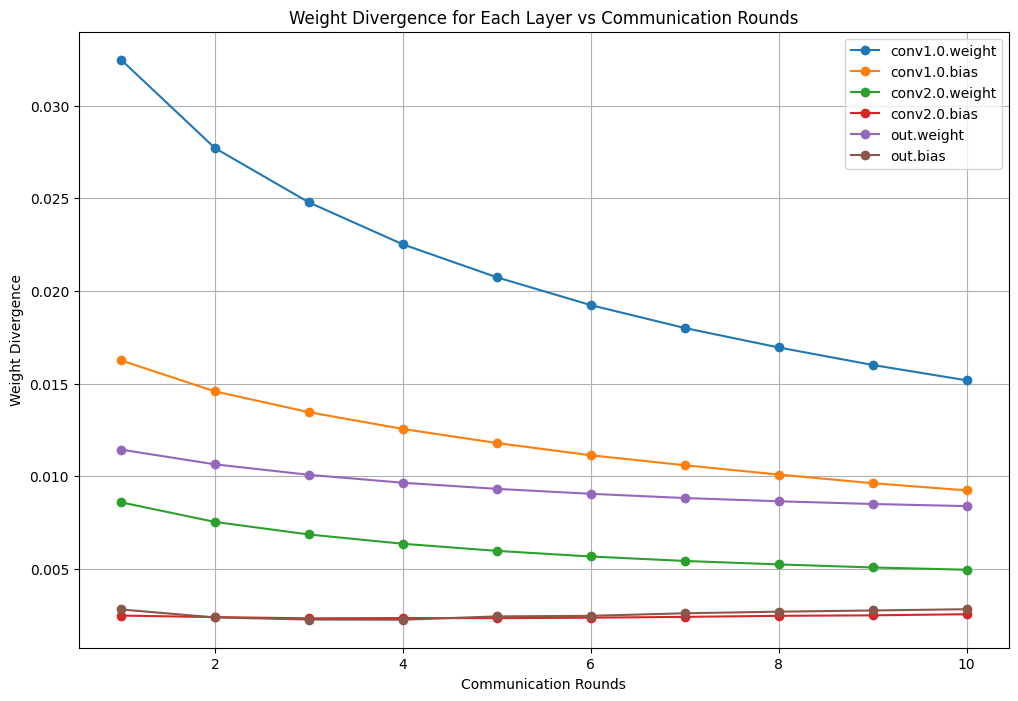

In [135]:
host6.plot_weight_divergence()

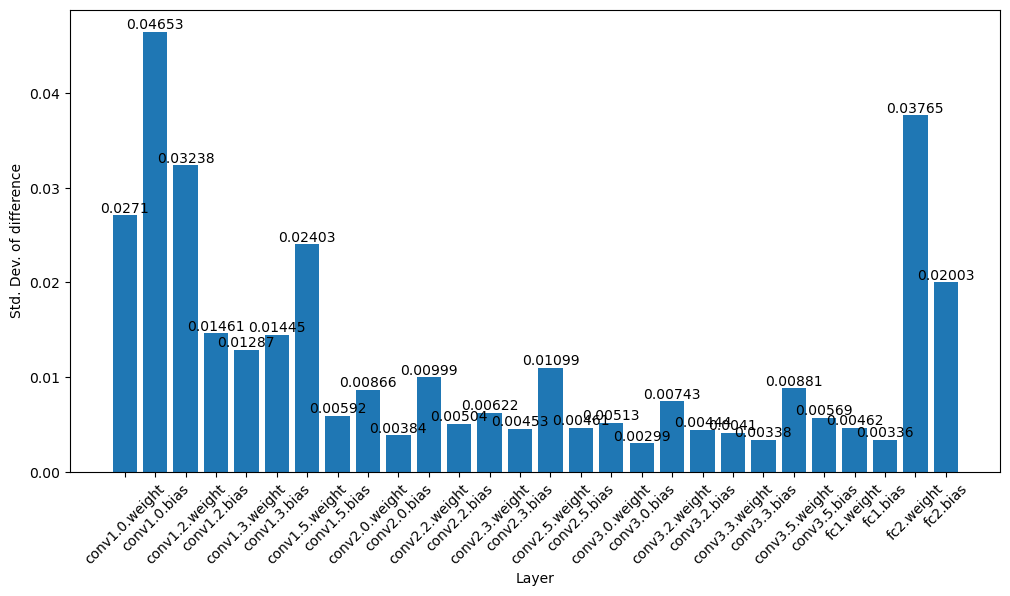

In [79]:
host6.plot_divergence()

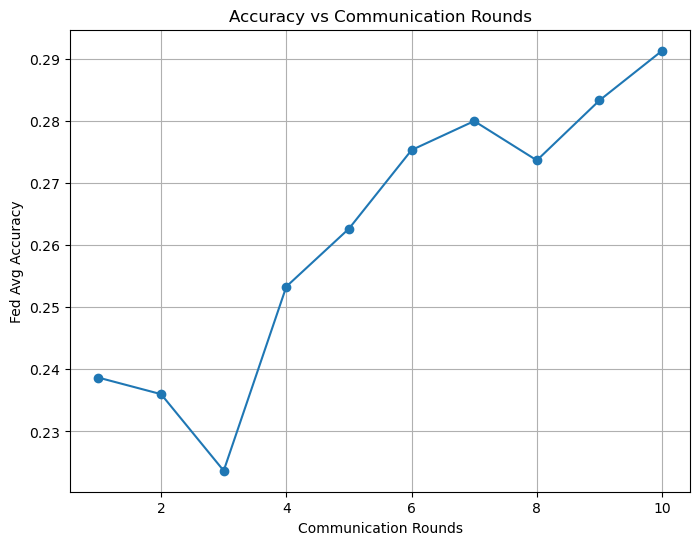

In [80]:
host6.plot_accuracy_per_round()

# Results

In [69]:
# hosts = [host0,host1,host3,host4,host2,host5,host6]
# host_names = ["IID","Non-IID (1)","Non-IID (2)","Non-IID (5)","Non-IID (1) w Sharing [10%]","Non-IID (1) w Warmup [3% 3E]","Non-IID (1) w Warmup [3% 3E] Sharing [10%]"]
hosts = [host0, host1]
host_names = ['IID', 'Non-IID (1)']

In [81]:
def compare_divergence(hosts, list_host_names):
    n=0
    layer_names=[]
    for name,layer in hosts[0].model.named_parameters():
        n+=1
        layer_names.append(name)
    r = np.arange(n)
    bar_width=0.1

    plt.figure(figsize=(15,6))
    for i in range(len(hosts)):
        central_stuff = dict()
        federated_stuff = dict()
        diff = dict()

        for name,layer in hosts[i].model.named_parameters():
            federated_stuff[name] = np.array(layer.detach().to("cpu"))

        for name,layer in hosts[i].central_train_model.named_parameters():
            central_stuff[name] = np.array(layer.detach().to("cpu"))

        for layer_name in central_stuff.keys():
            diff[layer_name] = np.std((central_stuff[layer_name]-federated_stuff[layer_name]))
        
        plt.bar(r+bar_width*i, diff.values(),width=bar_width,label=list_host_names[i])

    plt.grid(axis='y')
    plt.xlabel('Communication Rounds')
    plt.ylabel('Weight Divergence')
    plt.title('Comparing Weight Divergence')
    plt.xticks(r+bar_width*(n//2),layer_names)
    plt.legend()
    plt.show()

In [72]:
# compare_divergence(hosts)

## Training a Central SGD model

In [14]:
central_accuracies = []
central_train_results = []
def train_and_test_central_SGD(model,optimizer,loss_function,learning_rate,device,testset,trainset,epochs,rounds,
                 cnt_labels_noniid=CNT_LABELS_NON_IID_2,num_clients=NUM_CHILDREN,
                 max_cnt_per_client_train=MAX_CNT_CLIENT, max_cnt_per_client_test=MAX_CNT_CLIENT_TEST,
                 batch_size=BATCH_SIZE,iid=True, seed=SEED):
        if seed:
            torch.manual_seed(seed)
            np.random.seed(seed)
            random.seed(seed)
        central_model_SGD = model().to(device)
        central_model_SGD.load_state_dict(central_model_SGD.state_dict())
        central_train_optim =  optimizer(central_model_SGD.parameters(), lr=learning_rate)
        loss_func = loss_function().to(device)
        train_full_dataloader = torch.utils.data.DataLoader(truncate_dataset_new(trainset, iid=iid, max_cnt_per_client=max_cnt_per_client_train,num_clients=num_clients),batch_size=num_clients*batch_size,shuffle=True)
        test_full_dataloader = torch.utils.data.DataLoader(truncate_dataset_new(testset, iid=iid, max_cnt_per_client=max_cnt_per_client_test, num_clients=num_clients),batch_size=num_clients*batch_size,shuffle=True)
        for epoch in range(epochs*rounds):
            # train
            print(f"E{epoch+1} ",end="")
            central_model_SGD.train()
            running_loss = 0.0
            for inputs,labels in train_full_dataloader:
                inputs,labels = inputs.to(device),labels.to(device)
                central_model_SGD.zero_grad()
                output = central_model_SGD(inputs)
                loss = loss_func(output, labels)
                loss.backward()
                central_train_optim.step()
                running_loss += loss.item()*inputs.size(0)
            # test
            central_model_SGD.eval()
            correct = 0
            total = 0
            testing_loss = 0.0
            with torch.no_grad():
                for inputs,labels in test_full_dataloader:
                    inputs,labels = inputs.to(device),labels.to(device)
                    output = central_model_SGD(inputs)
                    _, predicted = torch.max(output.data, 1)
                    testing_loss+=loss_func(output,labels).sum().item()
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    avg_loss = (running_loss/len(test_full_dataloader.dataset))
            accuracy = correct / total
            central_train_results.append(avg_loss)
            central_accuracies.append(accuracy)
        central_accuracy_SGD = central_accuracies[-1]
        accuracy_sliced = [central_accuracies[i] for i in range(0, epochs*rounds, epochs)]
        print("")
        print(f"Central Accuracy: {100*central_accuracy_SGD}")
        plt.figure(figsize=(8, 6))
        # plt.plot(range(1, epochs*rounds+1, epochs), accuracy_sliced, marker='o')
        plt.plot(range(1, rounds+1), accuracy_sliced, marker='o', label='SGD')
        plt.xlabel('Communication Rounds')
        plt.ylabel('SGD Accuracy')
        plt.title('Accuracy vs Communication Rounds')
        plt.grid(True)
        plt.show()


E1 E2 E3 E4 E5 E6 E7 E8 E9 E10 E11 E12 E13 E14 E15 E16 E17 E18 E19 E20 E21 E22 E23 E24 E25 E26 E27 E28 E29 E30 
Central Accuracy: 67.88333333333333


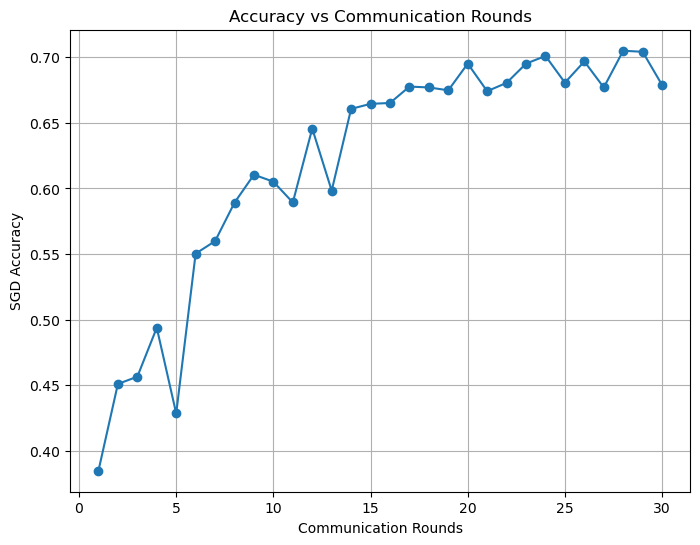

In [15]:
train_and_test_central_SGD(
    model=Modified_CNN_CIFAR10,
    optimizer=optim.SGD,
    loss_function=nn.CrossEntropyLoss,
    learning_rate=LEARNING_RATE,
    device=device,
    num_clients=NUM_CHILDREN,
    testset=testset,
    trainset=trainset,
    epochs=EPOCHS,
    iid=False,
    rounds=ROUNDS,
    seed=SEED
)

In [82]:
def compare_accuracy(hosts, list_host_names):
    plt.figure(figsize=(12, 8))
    for i in range(len(hosts)):
        plt.plot(range(0,ROUNDS+1),([0]+hosts[i].accuracies),marker='o',label=list_host_names[i])
    accuracy_sliced = [central_accuracies[i] for i in range(0, EPOCHS*ROUNDS, EPOCHS)]
    plt.plot(range(0, ROUNDS+1), ([0]+accuracy_sliced), marker='o', label='SGD')
    plt.title('Accuracy vs Communication Rounds')
    plt.xlabel('Communication Rounds')
    plt.ylabel('Accuracy')
    plt.grid(True)
    # plt.ylim(0.3, 1.0)
    plt.legend()
    plt.show()

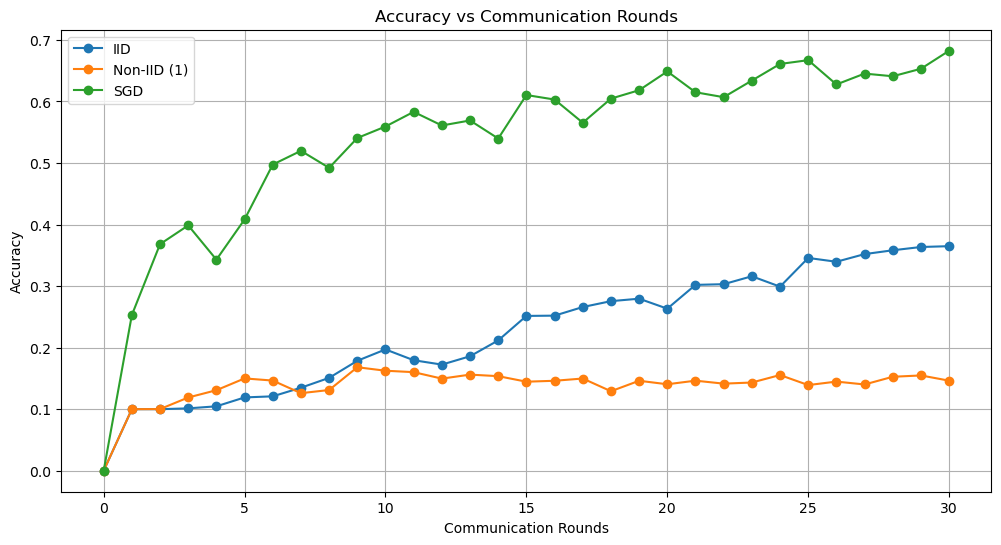

In [77]:
compare_accuracy(hosts)

Preparing host: 1
Training centralized model:
E1 E2 E3 E4 E5 E6 E7 E8 E9 E10 E11 E12 E13 E14 E15 E16 E17 E18 E19 E20 E21 E22 E23 E24 E25 E26 E27 E28 E29 E30 
Central Accuracy: 66.36666666666666
Round: 1
Client 0 is training.
E1 
Client 1 is training.
E1 
Client 2 is training.
E1 
Client 3 is training.
E1 
Client 4 is training.
E1 
Client 5 is training.
E1 
Client 6 is training.
E1 
Client 7 is training.
E1 
Client 8 is training.
E1 
Client 9 is training.
E1 
Client 10 is training.
E1 
Client 11 is training.
E1 
Client 12 is training.
E1 
Client 13 is training.
E1 
Client 14 is training.
E1 
Loss: 2.9412718594074247
Round: 2
Client 0 is training.
E1 
Client 1 is training.
E1 
Client 2 is training.
E1 
Client 3 is training.
E1 
Client 4 is training.
E1 
Client 5 is training.
E1 
Client 6 is training.
E1 
Client 7 is training.
E1 
Client 8 is training.
E1 
Client 9 is training.
E1 
Client 10 is training.
E1 
Client 11 is training.
E1 
Client 12 is training.
E1 
Client 13 is training.
E1 


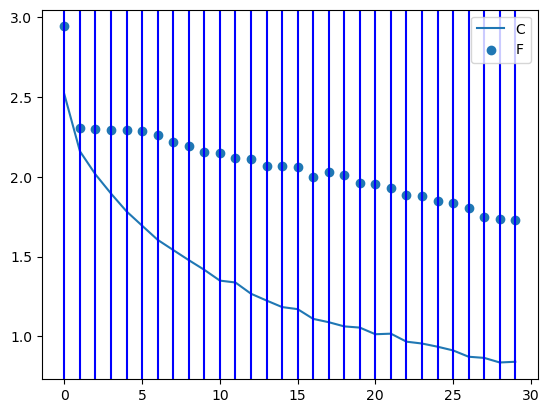

Preparing host: 2
Training centralized model:
E1 E2 E3 E4 E5 E6 E7 E8 E9 E10 E11 E12 E13 E14 E15 E16 E17 E18 E19 E20 E21 E22 E23 E24 E25 E26 E27 E28 E29 E30 
Central Accuracy: 66.36666666666666
Round: 1
Client 0 is training.
E1 
Client 1 is training.
E1 
Client 2 is training.
E1 
Client 3 is training.
E1 
Client 4 is training.
E1 
Client 5 is training.
E1 
Client 6 is training.
E1 
Client 7 is training.
E1 
Client 8 is training.
E1 
Client 9 is training.
E1 
Client 10 is training.
E1 
Client 11 is training.
E1 
Client 12 is training.
E1 
Client 13 is training.
E1 
Client 14 is training.
E1 
Loss: 2.6432125151157377
Round: 2
Client 0 is training.
E1 
Client 1 is training.
E1 
Client 2 is training.
E1 
Client 3 is training.
E1 
Client 4 is training.
E1 
Client 5 is training.
E1 
Client 6 is training.
E1 
Client 7 is training.
E1 
Client 8 is training.
E1 
Client 9 is training.
E1 
Client 10 is training.
E1 
Client 11 is training.
E1 
Client 12 is training.
E1 
Client 13 is training.
E1 


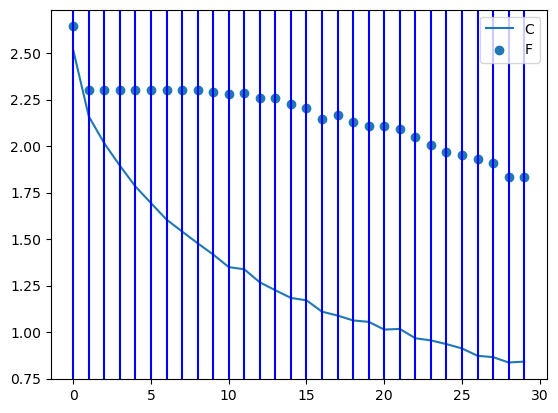

Preparing host: 3
Training centralized model:
E1 E2 E3 E4 E5 E6 E7 E8 E9 E10 E11 E12 E13 E14 E15 E16 E17 E18 E19 E20 E21 E22 E23 E24 E25 E26 E27 E28 E29 E30 
Central Accuracy: 66.36666666666666
Round: 1
Client 0 is training.
E1 
Client 1 is training.
E1 
Client 2 is training.
E1 
Client 3 is training.
E1 
Client 4 is training.
E1 
Client 5 is training.
E1 
Client 6 is training.
E1 
Client 7 is training.
E1 
Client 8 is training.
E1 
Client 9 is training.
E1 
Client 10 is training.
E1 
Client 11 is training.
E1 
Client 12 is training.
E1 
Client 13 is training.
E1 
Client 14 is training.
E1 
Loss: 2.9749099612236023
Round: 2
Client 0 is training.
E1 
Client 1 is training.
E1 
Client 2 is training.
E1 
Client 3 is training.
E1 
Client 4 is training.
E1 
Client 5 is training.
E1 
Client 6 is training.
E1 
Client 7 is training.
E1 
Client 8 is training.
E1 
Client 9 is training.
E1 
Client 10 is training.
E1 
Client 11 is training.
E1 
Client 12 is training.
E1 
Client 13 is training.
E1 


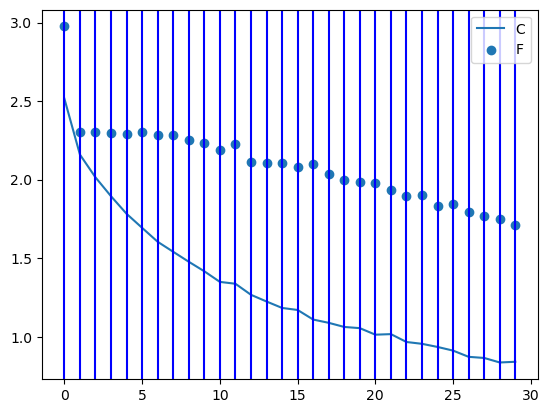

Preparing host: 4
Training centralized model:
E1 E2 E3 E4 E5 E6 E7 E8 E9 E10 E11 E12 E13 E14 E15 E16 E17 E18 E19 E20 E21 E22 E23 E24 E25 E26 E27 E28 E29 E30 
Central Accuracy: 66.36666666666666
Round: 1
Client 0 is training.
E1 
Client 1 is training.
E1 
Client 2 is training.
E1 
Client 3 is training.
E1 
Client 4 is training.
E1 
Client 5 is training.
E1 
Client 6 is training.
E1 
Client 7 is training.
E1 
Client 8 is training.
E1 
Client 9 is training.
E1 
Client 10 is training.
E1 
Client 11 is training.
E1 
Client 12 is training.
E1 
Client 13 is training.
E1 
Client 14 is training.
E1 
Loss: 2.418840062618256
Round: 2
Client 0 is training.
E1 
Client 1 is training.
E1 
Client 2 is training.
E1 
Client 3 is training.
E1 
Client 4 is training.
E1 
Client 5 is training.
E1 
Client 6 is training.
E1 
Client 7 is training.
E1 
Client 8 is training.
E1 
Client 9 is training.
E1 
Client 10 is training.
E1 
Client 11 is training.
E1 
Client 12 is training.
E1 
Client 13 is training.
E1 
C

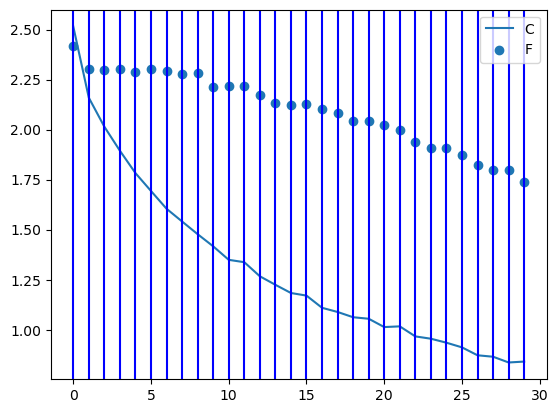

In [78]:
host00=host01=host02=host03=None
all_hosts_upd = [host00, host01, host02, host03]
host_names_upd = ['CNT (1)', 'CNT (3)', 'CNT (5)', 'CNT (7)']
label_cnt_per_client = 1
for i in range(len(all_hosts_upd)):
    all_hosts_upd[i] = HOST(
        model=Modified_CNN_CIFAR10,
        optimizer=optim.SGD,
        loss_function=nn.CrossEntropyLoss,
        learning_rate=LEARNING_RATE,
        device=device,
        num_clients=NUM_CHILDREN,
        testset=testset,
        trainset=trainset,
        epochs=EPOCHS,
        rounds=ROUNDS,
        iid=False,
        cnt_labels_noniid=label_cnt_per_client,
        seed=SEED
    )
    print(f"Preparing host: {i+1}")
    all_hosts_upd[i].run_central_and_federated_and_display()
    label_cnt_per_client+=2

In [79]:
all_hosts_upd.append(host0)
host_names_upd.append('IID')

In [84]:
# compare_divergence(all_hosts_upd, host_names_upd)

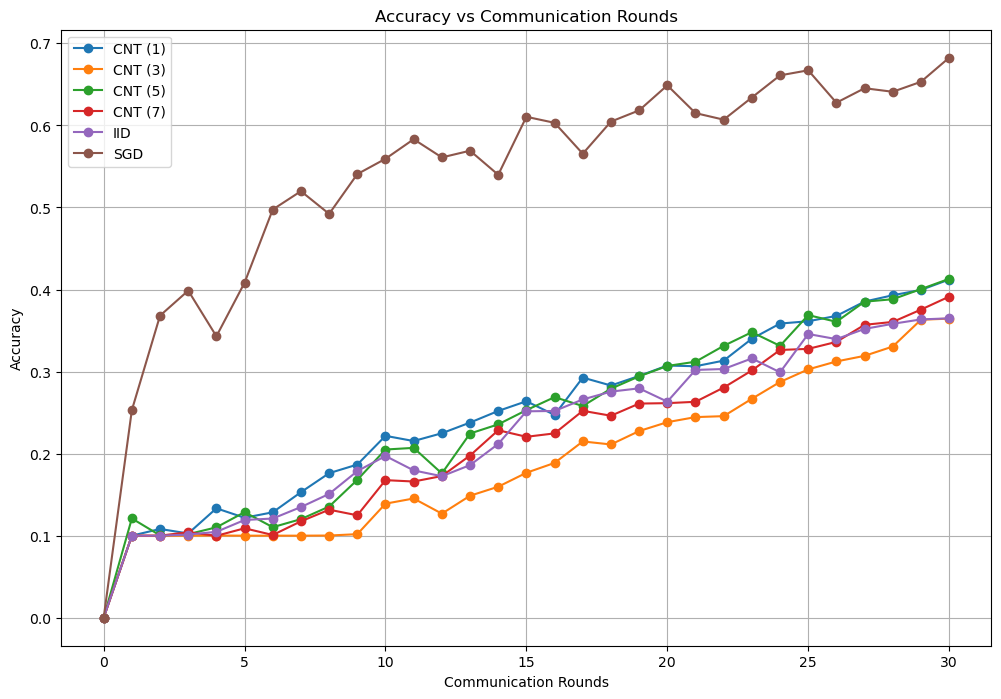

In [85]:
compare_accuracy(all_hosts_upd, host_names_upd)